In [1]:
from pathlib import Path
import sys


import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
import logging
import tifffile
from colokroll.core.format_converter import FormatConverter
from colokroll.data_processing import ImageLoader
from colokroll.imaging_preprocessing.background_subtraction.background_subtractor import BackgroundSubtractor
from colokroll.analysis.cell_segmentation import CellSegmenter
from colokroll.analysis.colocalization import compute_colocalization, export_colocalization_json
from colokroll.imaging_preprocessing.z_slice_detection import select_z_slices

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

In [2]:
from pathlib import Path
from colokroll.data_processing.image_loader import ImageLoader
from colokroll.imaging_preprocessing.z_slice_detection import select_z_slices

image_path = Path("/fs/scratch/PAS2598/duarte63/ALIX_confocal_data/ALIX/nd2/anti_ALIX_ctrl_3.ome.tiff")

# Step 1: Load the image
image_loader = ImageLoader()
loaded_data = image_loader.load_image(image_path)

# Check metadata
pixel_size = image_loader.get_pixel_size()
print(f"Pixel size: {pixel_size} μm")
print(f"Data type: {loaded_data.dtype}")
print(f"Shape: {loaded_data.shape}")

# Step 2: Run z-slice selection
result = select_z_slices(
    loaded_data,
    method="combined",
    strategy="relative",
    threshold=0.6,
    smooth=3
)

# Step 3: Filter to keep only selected slices
filtered_image = loaded_data[result.indices_keep]
print(f"Kept {len(result.indices_keep)} slices out of {loaded_data.shape[0]}")

INFO: Found 1 Channel elements but SizeC is 4. Adding default names.
INFO: Extracted metadata from OME-XML: pixel_size=0.108333333333333μm, channels=4
INFO: Squeezed singleton dim(s): (25, 1800, 1800, 4, 1) -> (25, 1800, 1800, 4)
INFO: Successfully loaded TIFF image with shape: (25, 1800, 1800, 4)


Pixel size: 0.108333333333333 μm
Data type: uint16
Shape: (25, 1800, 1800, 4)
Kept 15 slices out of 25


In [3]:
channel_names = image_loader.get_channel_names()
channel_names
# AF488 -> ALIX, AF647 -> LAMP1, AF568 -> Phalloidin, DAPI -> DAPI

['Channel_0', 'Channel_1', 'Channel_2', 'Channel_3']

In [4]:
# Step 4: Rename channels
new_channel_names = ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']
image_loader.rename_channels(new_channel_names)
channel_names = image_loader.get_channel_names()
print(f"Channels: {channel_names}")
# AF488 -> ALIX, AF647 -> LAMP1, AF568 -> Phalloidin, DAPI -> DAPI

INFO: Renamed channels to: ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


Channels: ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


In [5]:
bg_subtractor = BackgroundSubtractor()

results = {}

for i, ch in enumerate(channel_names):
    ch_data = filtered_image[:, :, :, i]
    t0 = time.perf_counter()
    corrected, meta = bg_subtractor.subtract_background(
        image=ch_data,
        channel_name=ch,
        # method omitted -> auto search + full run
    )
    cp.cuda.Stream.null.synchronize()
    dt = time.perf_counter() - t0

    results[ch] = (corrected, meta)

INFO: Initializing CUDA-accelerated background subtractor (CUDA required)
INFO: GPU Memory: 39.1GB free / 39.5GB total
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=50)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=55)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=60)
INFO: Processing 15 z-slices with CUDA rolling ball approximation (radius=50)
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=10
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=12
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=14
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=16
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=10
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=100)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=110)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radiu

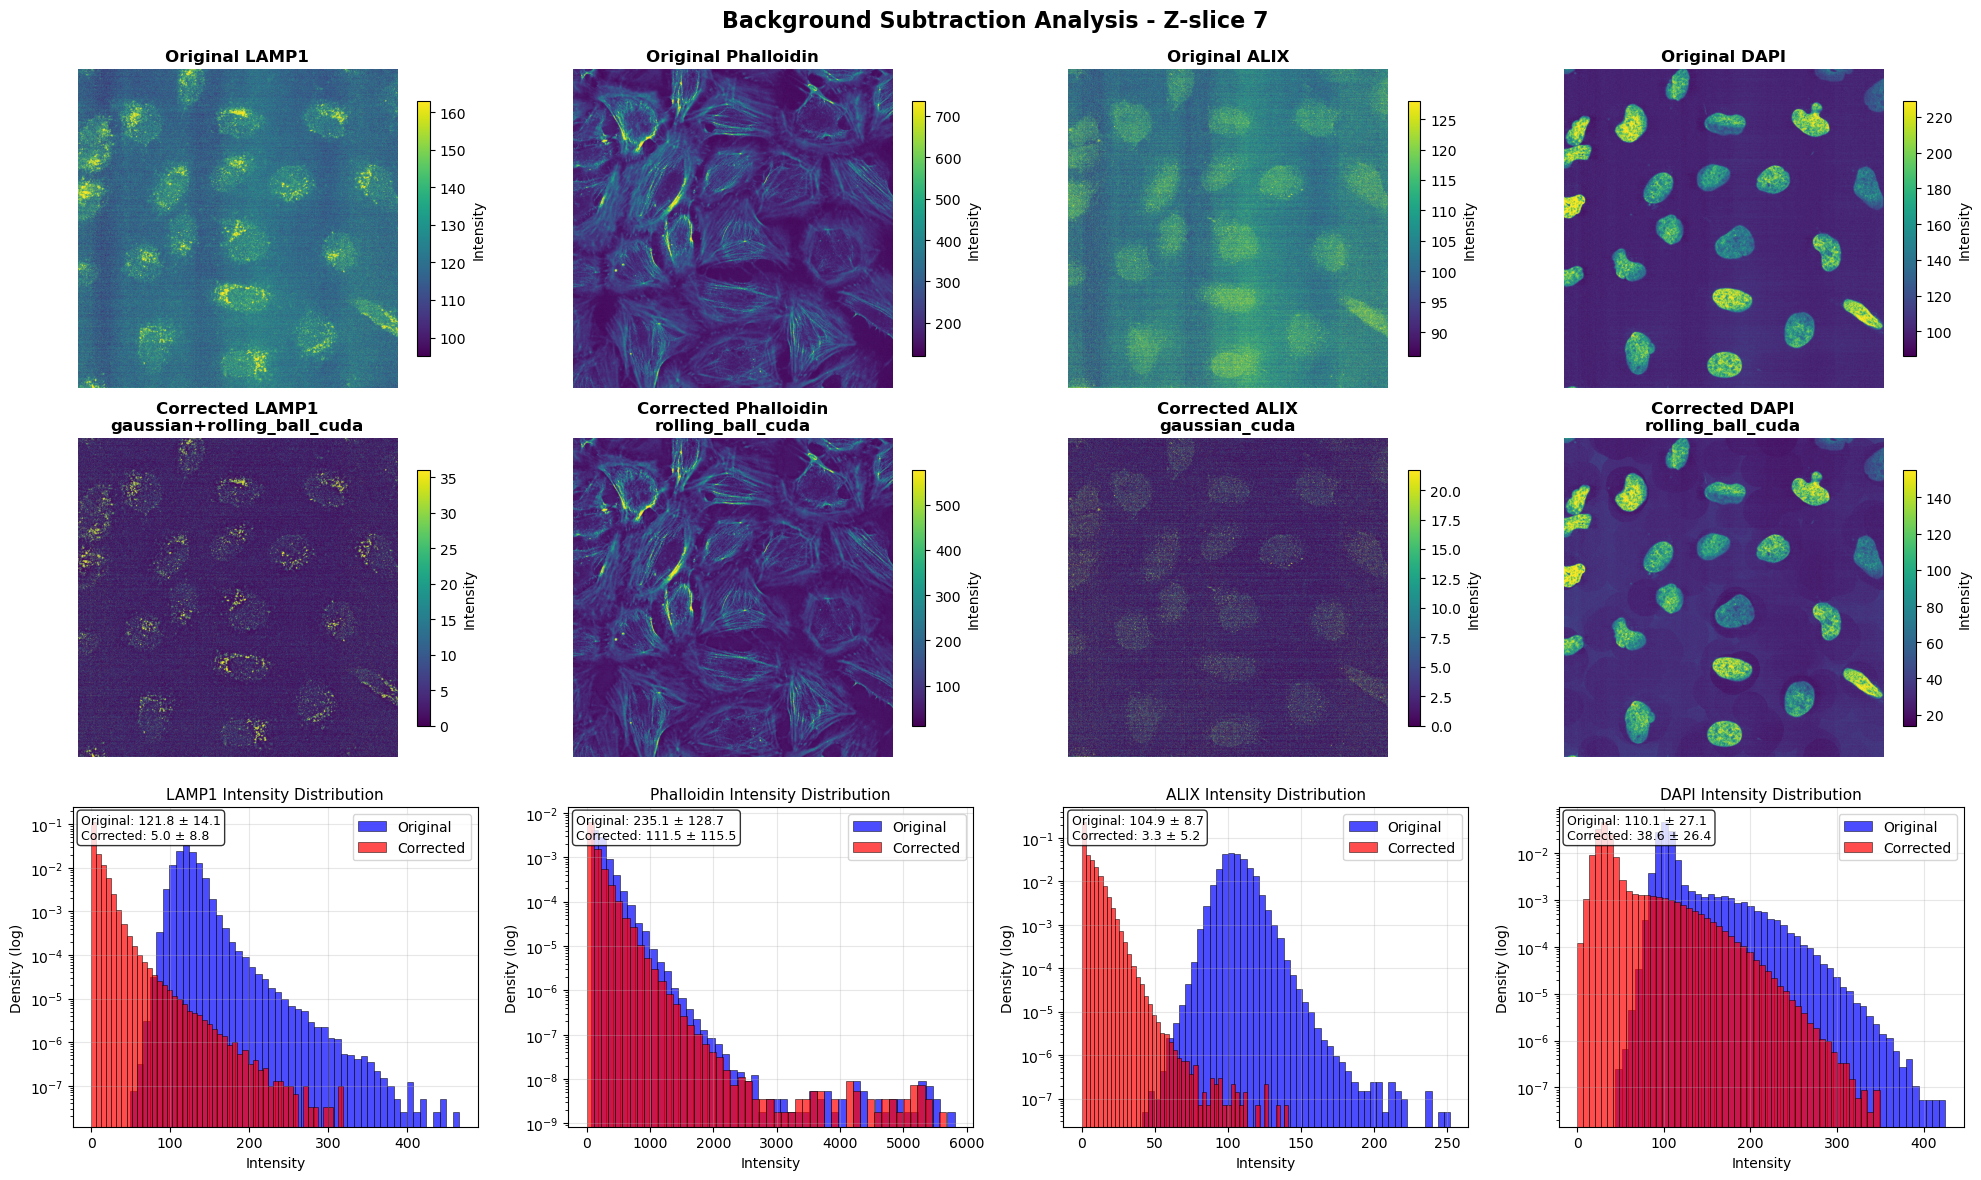

In [6]:
middle_slice_idx = filtered_image.shape[0]//2


fig = bg_subtractor.plot_background_subtraction_comparison(
    original_data=filtered_image,
    corrected_results=results,
    channel_names=channel_names,
    z_slice=middle_slice_idx,
    figsize=(5*len(channel_names), 12)
)
plt.show()

Loaded as API: https://mouseland-cellpose.hf.space ✔


INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/config "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/info?serialize=False "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/heartbeat/8dd0e49d-4be3-4373-a4c3-1c5b88db0e47 "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://mouseland-cellpose.hf.space/gradio_api/upload "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://mouseland-cellpose.hf.space/gradio_api/queue/join "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/queue/data?session_hash=8dd0e49d-4be3-4373-a4c3-1c5b88db0e47 "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/file=/tmp/gradio/7d13d7050c2f970d8e6c11a42cce19d0fbc480d29173ae918dc46af772695455/composite.png "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/file=/tmp/gradio/7d13d7050c2f970d8e6c11a42cce19d0fbc480d29173ae91

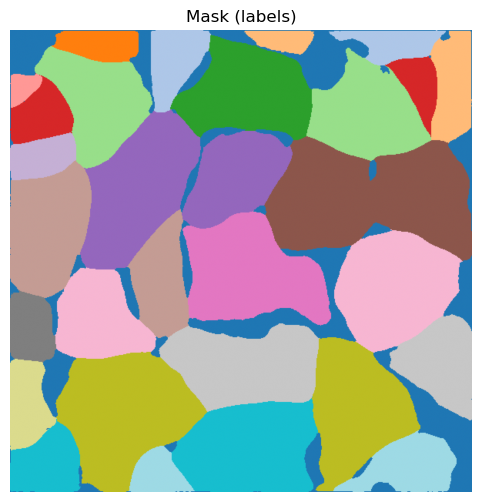

In [7]:
from gradio_client import Client, handle_file
from colokroll.analysis.segmentation_config import get_hf_token
import imageio.v3 as iio
import os

# 0) Build/validate composite (if not already done)
def norm01(a):
    a = a.astype(np.float32); mn, mx = a.min(), a.max()
    return np.zeros_like(a) if mx <= mn else (a - mn) / (mx - mn)
ph_idx = channel_names.index("Phalloidin"); da_idx = channel_names.index("DAPI")
ph_mip = loaded_data[..., ph_idx].max(axis=0).astype(np.float32)
da_mip = loaded_data[..., da_idx].max(axis=0).astype(np.float32)
composite = 0.8*norm01(ph_mip) + 0.2*norm01(da_mip)
composite = np.clip(np.nan_to_num(composite, nan=0.0, posinf=1.0, neginf=0.0), 0, 1).astype(np.float32)

# 1) temp PNG
tmp_png = "/tmp/composite.png"
iio.imwrite(tmp_png, (composite*255).astype(np.uint8))

# 2) Authenticated client
token = get_hf_token()
client = Client("mouseland/cellpose", hf_token=token)

# 3) Two-step flow with pause + retry
def run_seg(resize):
    _ = client.predict(filepath=handle_file(tmp_png), api_name="/update_button") 
    time.sleep(1.0)
    return client.predict(
        filepath=[handle_file(tmp_png)],
        resize=resize, max_iter=250, flow_threshold=0.4, cellprob_threshold=0.0,
        api_name="/cellpose_segment",
    )

result = None
for rs in (600, 400):
    try:
        result = run_seg(rs)
        break
    except Exception as e:
        print(f"retry with smaller resize due to: {e}")
        time.sleep(1.0)

if result is None:
    raise RuntimeError("Cellpose Space failed after retries")

# 4) outputs and save to folder
masks_tif = result[2]["value"] if isinstance(result[2], dict) else (result[2].path if hasattr(result[2],"path") else result[2])
outlines_png = result[3]["value"] if isinstance(result[3], dict) else (result[3].path if hasattr(result[3],"path") else result[3])

mask = iio.imread(str(masks_tif)).astype(np.int32)
save_dir = Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose"); save_dir.mkdir(parents=True, exist_ok=True)
dst_mask = save_dir / f"{image_path.stem}_phall_dapi_masks.tif"
dst_outl = save_dir / f"{image_path.stem}_phall_dapi_outlines.png"
Path(dst_mask).write_bytes(Path(masks_tif).read_bytes())
Path(dst_outl).write_bytes(Path(outlines_png).read_bytes())

plt.figure(figsize=(6,6))
plt.title("Mask (labels)")
plt.imshow(mask, cmap="tab20")
plt.axis("off")
plt.show()

INFO: Loading TIF mask: /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_ctrl_3.ome_phall_dapi_masks.tif
INFO: Mask contains 33 unique values
INFO: Successfully loaded mask with shape: (1800, 1800)
INFO: Loaded labeled mask with integer dtype: uint16
INFO: Estimated min_area threshold: fraction=0.7, median_area=80325 -> thr=56227
INFO: Starting compute_colocalization(ch_a=ALIX, ch_b=LAMP1, normalization_scope=none, min_area=56227, max_border_fraction=0.05, border_margin_px=1, plot_mask=True)
INFO: Loading TIF mask: /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_ctrl_3.ome_phall_dapi_masks.tif
INFO: Mask contains 33 unique values
INFO: Successfully loaded mask with shape: (1800, 1800)
INFO: Loaded labeled mask with integer dtype: uint16
INFO: Image loaded: shape=(15, 1800, 1800, 4), channels=['LAMP1', 'Phalloidin', 'ALIX', 'DAPI'] | Mask loaded: shape=(1800, 1800), unique_labels=32
INFO: Manders coefficients (M1/M2) will be computed per-Z-slice with independent threshold

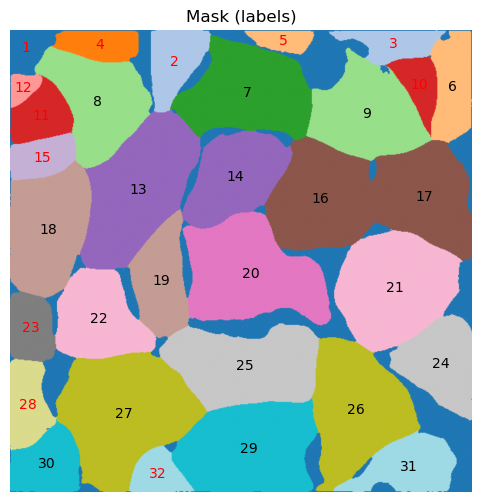

INFO: Displayed mask with label indices (kept=20, removed=12)
INFO: Normalization disabled (scope='none')
INFO: Computed metrics for 20 labels; total_image n_voxels=38181375.0
INFO: compute_colocalization finished.


In [10]:
import pandas as pd
from colokroll.analysis.colocalization import _load_mask, estimate_min_area_threshold

channels = channel_names 

mask_path = Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_ctrl_3.ome_phall_dapi_masks.tif")

min_area = estimate_min_area_threshold(mask_path, fraction_of_median=0.70)

res = compute_colocalization(
    image=results,  # dict[str, (array, meta)] or dict[str, array]
    mask=mask_path,
    channel_a="ALIX",
    channel_b="LAMP1",
    thresholding='otsu',
    max_border_fraction=0.05,
    min_area=int(min_area),
    border_margin_px=1,
    plot_mask=True,
)

res["results"]["total_image"]

# Per-cell dataframe (one row per kept label)
df_cells = pd.DataFrame(res["results"]["per_label"]).sort_values("label")
# Optional: save

# Total-image (single row)
df_total = pd.DataFrame([res["results"]["total_image"]])

In [12]:
df_cells
df_cells.to_csv("per_cell_metrics_ctrl_3.csv", index=False)